In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Post frequency analysis

In [2]:
index_df = pd.read_csv('stock_index.csv')
index_df['created_utc'] = pd.to_datetime(index_df['created_utc'], unit='s')

In [3]:
frequency_df = index_df.groupby([pd.Grouper(key='created_utc', freq='D'), 'stock_symbol']).size().unstack('stock_symbol')

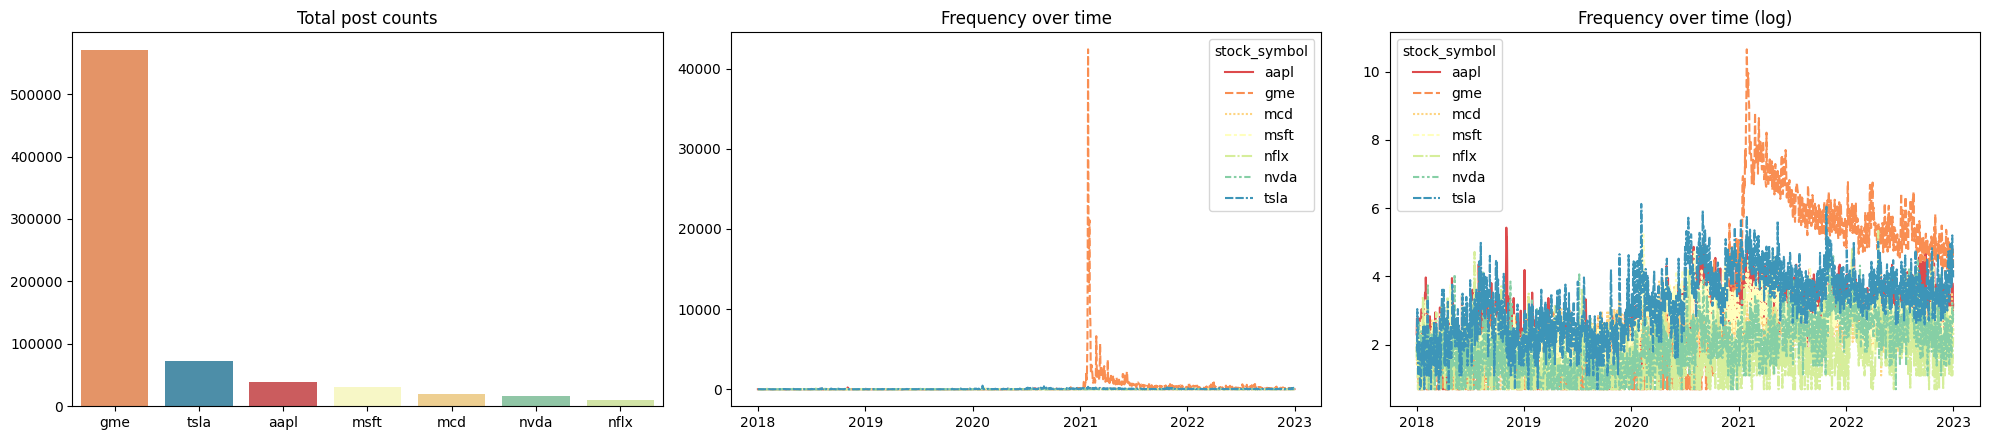

In [4]:
# Sum frequencies
sum_freq = frequency_df.sum()

# Get a consistent color palette
palette = sns.color_palette("Spectral", len(sum_freq))
color_dict = dict(zip(sum_freq.index, palette))

# Now sort the sum frequencies for the barplot
sum_freq_sorted = sum_freq.sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(20, 4.5))

sns.barplot(x=sum_freq_sorted.index, y=sum_freq_sorted.values, ax=axes[0], palette=color_dict)
sns.lineplot(data=frequency_df, ax=axes[1], palette=color_dict)
sns.lineplot(data=frequency_df.apply(np.log1p), ax=axes[2], palette=color_dict)

axes[0].set_title("Total post counts")
axes[1].set_title("Frequency over time")
axes[2].set_title("Frequency over time (log)")

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Sentiment distribution analysis

In [5]:
files = [f for f in os.listdir('sentiment') if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join('sentiment', f)) for f in files]

In [6]:
sent_df = pd.concat(dfs, axis=0)
sent_df = sent_df.drop_duplicates()

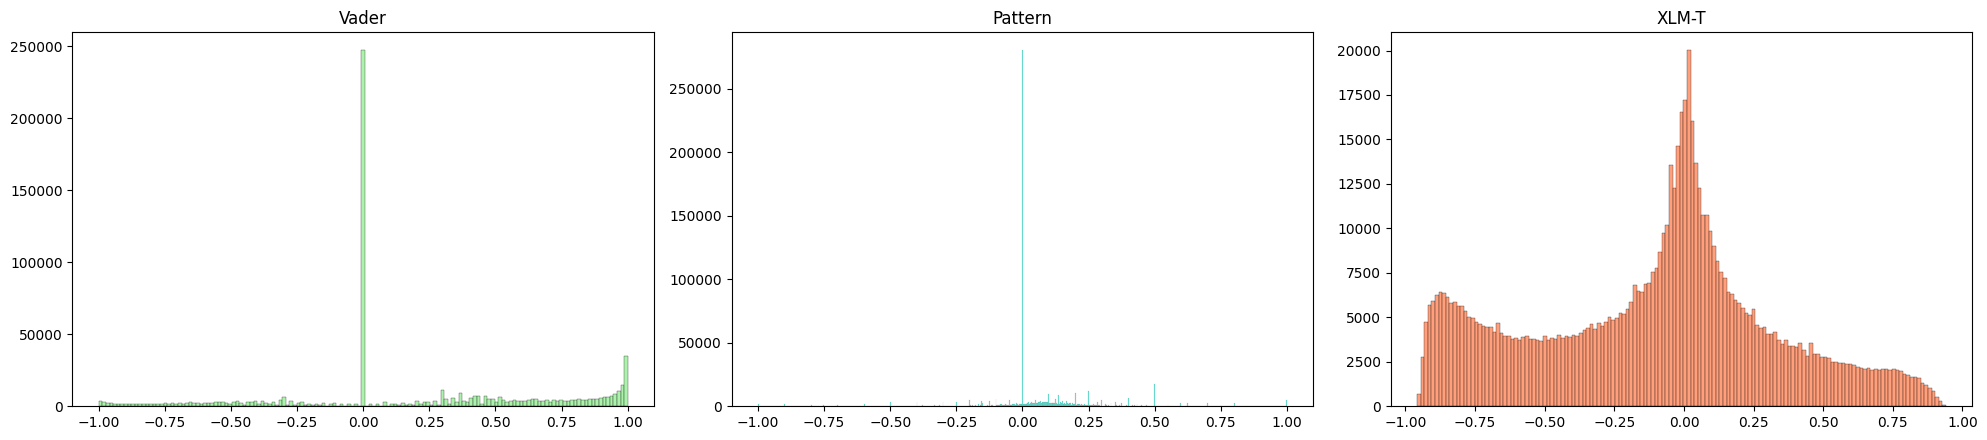

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4.5))

sns.histplot(sent_df['polarity_vader'], color='lightgreen', ax=axes[0])
sns.histplot(sent_df['polarity_pattern'], color='turquoise', ax=axes[1])
sns.histplot(sent_df['polarity_xlm-t'], color='coral', ax=axes[2])

axes[0].set_title("Vader")
axes[1].set_title("Pattern")
axes[2].set_title("XLM-T")

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [8]:
# Vader 0 sentiment percentage
l = len(sent_df)
len(sent_df[sent_df['polarity_vader'] == 0]) / l

0.3398049440575597

In [9]:
# Pattern 0 sentiment percentage
l = len(sent_df)
len(sent_df[sent_df['polarity_pattern'] == 0]) / l

0.3836554011683554

In [10]:
# XLM-T 0 sentiment percentage
l = len(sent_df)
len(sent_df[sent_df['polarity_xlm-t'] == 0]) / l

0.0

In [11]:
# Vader 0 sentiment post length stats
sent_df[sent_df['polarity_vader'] == 0]['combined'].apply(len).describe()

count    247098.000000
mean         81.202628
std         419.944656
min           4.000000
25%          27.000000
50%          46.000000
75%          75.000000
max       37956.000000
Name: combined, dtype: float64

In [12]:
# Pattern 0 sentiment post length stats
sent_df[sent_df['polarity_pattern'] == 0]['combined'].apply(len).describe()

count    278985.000000
mean         79.376167
std         346.790944
min           4.000000
25%          29.000000
50%          48.000000
75%          78.000000
max       36870.000000
Name: combined, dtype: float64

In [13]:
# Average post length stats
sent_df['combined'].apply(len).describe()

count    727176.000000
mean        818.027066
std        2735.049802
min           4.000000
25%          49.000000
50%         101.000000
75%         386.000000
max       52262.000000
Name: combined, dtype: float64

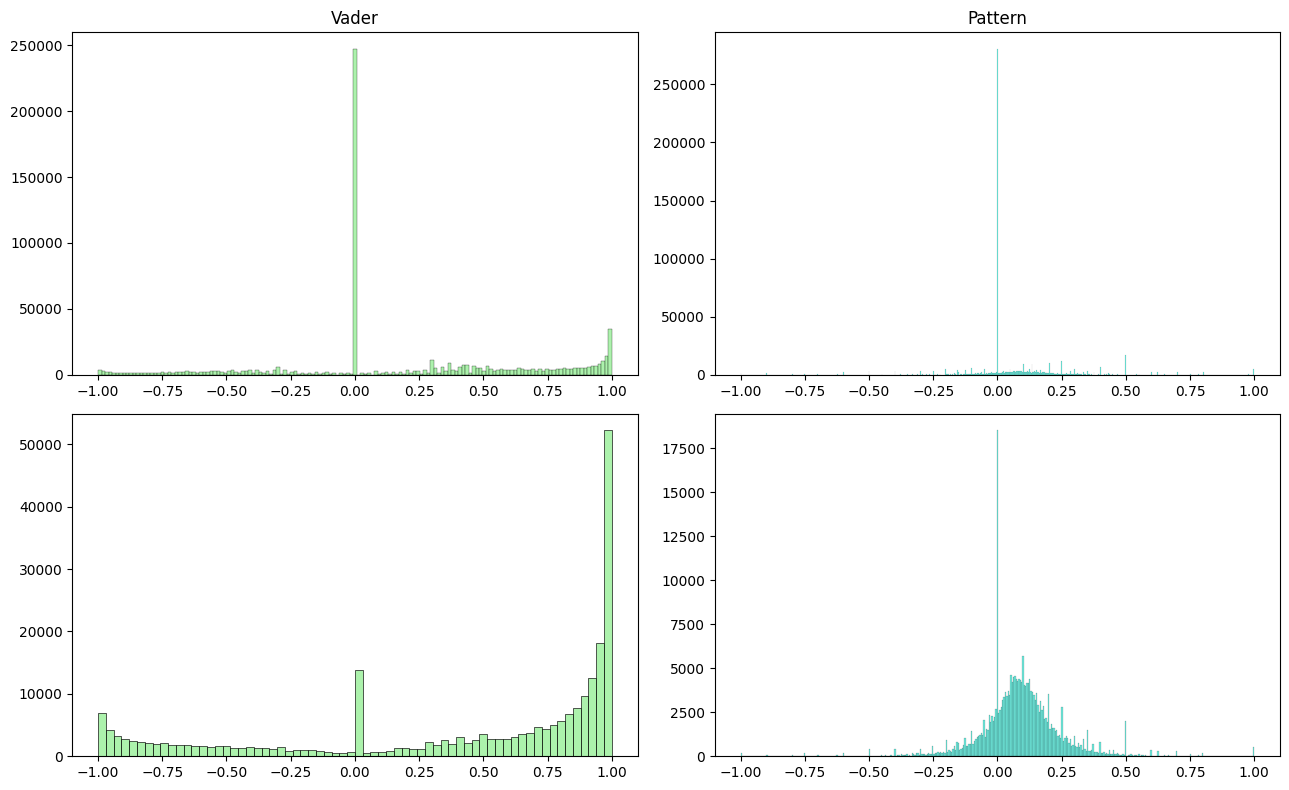

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))

sns.histplot(sent_df['polarity_vader'], color='lightgreen', ax=axes[0, 0])
sns.histplot(sent_df['polarity_pattern'], color='turquoise', ax=axes[0, 1])

cleaned_df = sent_df[
    (sent_df['selftext'].notna())
    & (sent_df['is_deleted'] == False)
    & (sent_df['is_removed'] == False)
    & (sent_df['combined'].apply(len) > 75)
]

sns.histplot(cleaned_df['polarity_vader'], color='lightgreen', ax=axes[1, 0])
sns.histplot(cleaned_df['polarity_pattern'], color='turquoise', ax=axes[1, 1])

axes[0, 0].set_title("Vader")
axes[0, 1].set_title("Pattern")

for a in axes:
    for ax in a:
        ax.set_xlabel('')
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

## Sentiment trend analysis

In [15]:
sent_df['created_utc'] = pd.to_datetime(sent_df['created_utc'])
cleaned_df['created_utc'] = pd.to_datetime(cleaned_df['created_utc'])
merged_df = index_df.merge(sent_df, on=['id', 'created_utc'], how='left')

/var/tmp/ipykernel_76845/2306453654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['created_utc'] = pd.to_datetime(cleaned_df['created_utc'])


In [16]:
# merged_df['combined'] = merged_df['combined'].fillna('')
cleaned_merged_df = merged_df[
    (merged_df['selftext'].notna())
    & (merged_df['is_deleted'] == False)
    & (merged_df['is_removed'] == False)
    & (merged_df['combined'].apply(len) > 75)
]

In [17]:
daily_stock_avgs = {}
daily_stock_avgs['vader'] = cleaned_merged_df.groupby([cleaned_merged_df['created_utc'].dt.date, 'stock_symbol'])['polarity_vader'].mean().reset_index()
daily_stock_avgs['pattern'] = cleaned_merged_df.groupby([cleaned_merged_df['created_utc'].dt.date, 'stock_symbol'])['polarity_pattern'].mean().reset_index()
daily_stock_avgs['xlm-t'] = merged_df.groupby([merged_df['created_utc'].dt.date, 'stock_symbol'])['polarity_xlm-t'].mean().reset_index()

In [18]:
daily_avgs = {}
daily_avgs['vader'] = cleaned_df.groupby(cleaned_df['created_utc'].dt.date)['polarity_vader'].mean().reset_index()
daily_avgs['pattern'] = cleaned_df.groupby(cleaned_df['created_utc'].dt.date)['polarity_pattern'].mean().reset_index()
daily_avgs['xlm-t'] = sent_df.groupby(sent_df['created_utc'].dt.date)['polarity_xlm-t'].mean().reset_index()

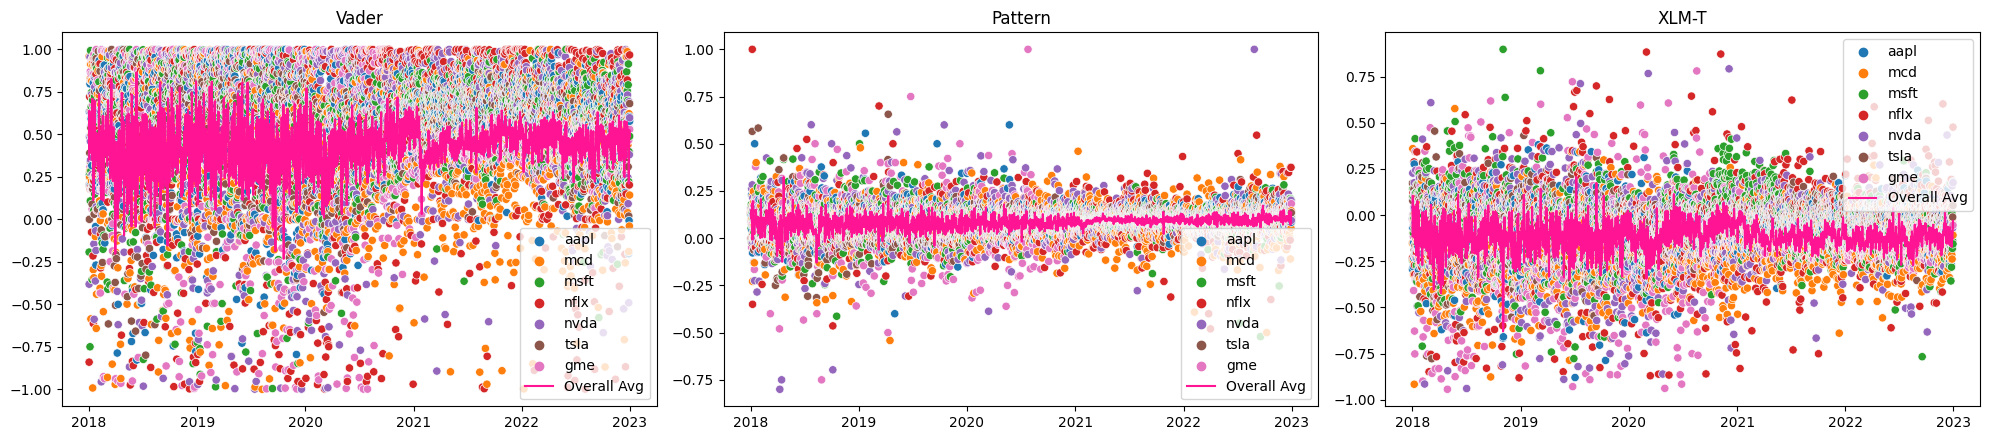

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4.5))

sns.scatterplot(data=daily_stock_avgs['vader'], x='created_utc', y='polarity_vader', hue='stock_symbol', ax=axes[0])
sns.scatterplot(data=daily_stock_avgs['pattern'], x='created_utc', y='polarity_pattern', hue='stock_symbol', ax=axes[1])
sns.scatterplot(data=daily_stock_avgs['xlm-t'], x='created_utc', y='polarity_xlm-t', hue='stock_symbol', ax=axes[2])

sns.lineplot(data=daily_avgs['vader'], x='created_utc', y='polarity_vader', color='deeppink', label='Overall Avg', ax=axes[0])
sns.lineplot(data=daily_avgs['pattern'], x='created_utc', y='polarity_pattern', color='deeppink', label='Overall Avg', ax=axes[1])
sns.lineplot(data=daily_avgs['xlm-t'], x='created_utc', y='polarity_xlm-t', color='deeppink', label='Overall Avg', ax=axes[2])

axes[0].set_title("Vader")
axes[1].set_title("Pattern")
axes[2].set_title("XLM-T")

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [20]:
cleaned_df['polarity_vader'].describe()

count    245665.000000
mean          0.403778
std           0.663988
min          -1.000000
25%           0.000000
50%           0.722700
75%           0.956200
max           1.000000
Name: polarity_vader, dtype: float64

In [42]:
daily_avgs['vader']['created_utc'] = pd.to_datetime(daily_avgs['vader']['created_utc'])
print(daily_avgs['vader'][daily_avgs['vader']['created_utc'].dt.year == 2018].std())
print(daily_avgs['vader'][daily_avgs['vader']['created_utc'].dt.year == 2022].std())

created_utc       105 days 12:15:21.280456946
polarity_vader                       0.178577
dtype: object
created_utc       105 days 12:15:21.280456946
polarity_vader                       0.075537
dtype: object


In [24]:
cleaned_df['polarity_pattern'].describe()

count    245665.000000
mean          0.088432
std           0.170978
min          -1.000000
25%           0.000000
50%           0.082143
75%           0.164394
max           1.000000
Name: polarity_pattern, dtype: float64

In [43]:
daily_avgs['pattern']['created_utc'] = pd.to_datetime(daily_avgs['pattern']['created_utc'])
print(daily_avgs['pattern'][daily_avgs['pattern']['created_utc'].dt.year == 2018].std())
print(daily_avgs['pattern'][daily_avgs['pattern']['created_utc'].dt.year == 2022].std())

created_utc         105 days 12:15:21.280456946
polarity_pattern                       0.051035
dtype: object
created_utc         105 days 12:15:21.280456946
polarity_pattern                       0.018347
dtype: object


In [26]:
sent_df['polarity_xlm-t'].describe()

count    727176.000000
mean         -0.111391
std           0.438529
min          -0.958310
25%          -0.437085
50%          -0.040905
75%           0.145266
max           0.940964
Name: polarity_xlm-t, dtype: float64

In [44]:
daily_avgs['xlm-t']['created_utc'] = pd.to_datetime(daily_avgs['xlm-t']['created_utc'])
print(daily_avgs['xlm-t'][daily_avgs['xlm-t']['created_utc'].dt.year == 2018].std())
print(daily_avgs['xlm-t'][daily_avgs['xlm-t']['created_utc'].dt.year == 2022].std())

created_utc       105 days 12:15:21.280456946
polarity_xlm-t                       0.094423
dtype: object
created_utc       105 days 12:15:21.280456946
polarity_xlm-t                       0.046897
dtype: object


## Sentiment seasonality analysis

In [45]:
mean_df = daily_avgs['vader'].merge(daily_avgs['pattern'], on='created_utc', how='left')
mean_df = mean_df.merge(daily_avgs['xlm-t'], on='created_utc', how='left')
mean_df['created_utc'] = pd.to_datetime(mean_df['created_utc'])
mean_df.set_index('created_utc', inplace=True)

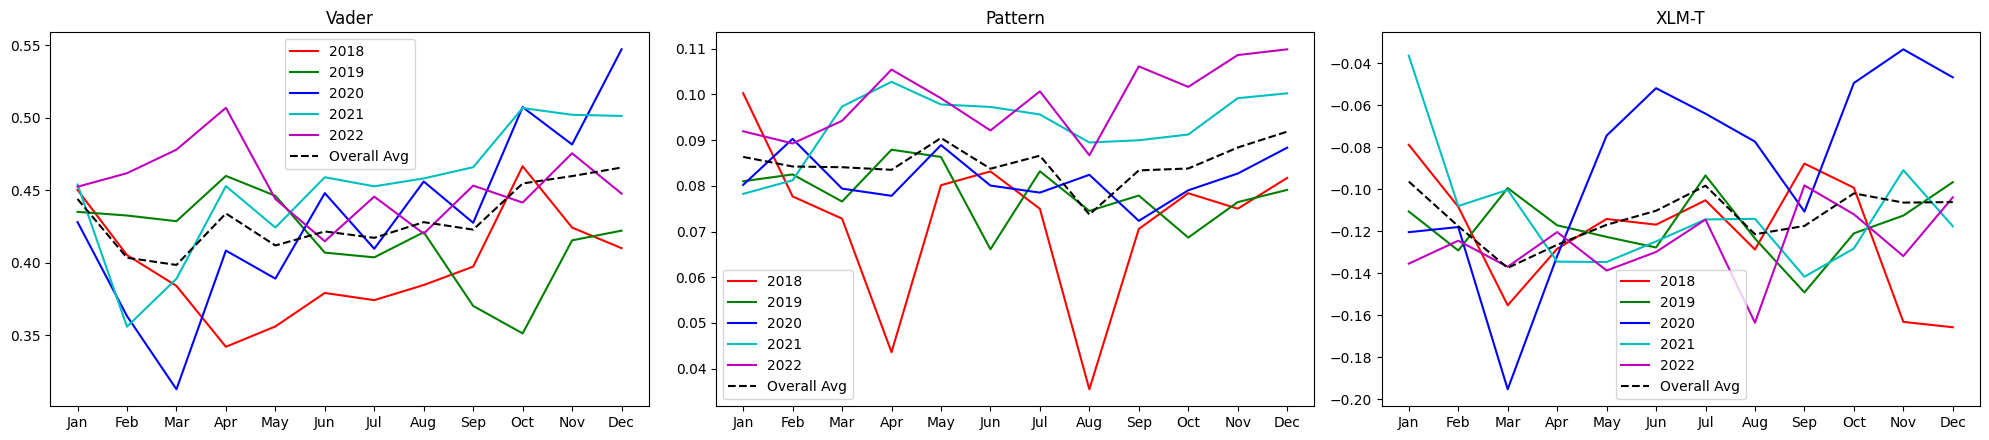

In [46]:
monthly_avgs = mean_df.groupby([mean_df.index.year, mean_df.index.month]).mean()
monthly_avgs.index.names = ['Year', 'Month']

overall_monthly_avgs = mean_df.groupby(mean_df.index.month).mean()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4.5))

columns = ['polarity_vader', 'polarity_pattern', 'polarity_xlm-t']
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for ax, column in zip(axes, columns):
    for year, color in zip(monthly_avgs.index.levels[0], colors):
        ax.plot(monthly_avgs.loc[year][column], label=f'{year}', color=color)
    
    ax.plot(overall_monthly_avgs[column], label='Overall Avg', linestyle='--', color='k')
    
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()

axes[0].set_title("Vader")
axes[1].set_title("Pattern")
axes[2].set_title("XLM-T")

plt.tight_layout()
plt.show()

In [47]:
overall_monthly_avgs

,polarity_vader,polarity_pattern,polarity_xlm-t
created_utc,,,
1,0.443893,0.086324,-0.096267
2,0.403416,0.084230,-0.117536
3,0.398433,0.084068,-0.137390
4,0.433952,0.083503,-0.126394
5,0.411853,0.090464,-0.116875
6,0.421535,0.083738,-0.110176
7,0.417127,0.086592,-0.098233
8,0.427939,0.073715,-0.121370
9,0.422789,0.083374,-0.117411


In [52]:
overall_monthly_avgs.mean(axis=0)

polarity_vader      0.430072
polarity_pattern    0.085003
polarity_xlm-t     -0.112990
dtype: float64